Playing with LeNet pruning
============

In this notebook I'll try to explain a couple of neural network pruning techniques I've tried and analyze the attempts that resulted in the largest compression.

Pruning was implemented on top of the code provided in Neural Networks and Deep Learning online book that I highly recommend for developing intuition behind neural networks. (http://neuralnetworksanddeeplearning.com/)

This work was inspired by Deep Compression work from Stanford (https://arxiv.org/abs/1510.00149). They have managed to compress LeNet-300-100 by 12x using pruning. They compressed it even further using other techniques, but I wanted to focus on attempting to replicate their result and maybe achieve a better performance.

All of the pruning attempts are based on one simple idea: set all the small weights (under certain threshold) to zero. Retrain. Try to set as many weights to zero as possible, before losing accuracy. Connections with zero weights are effectively non-existent since they are not used in forward propagation.

For now, pruning was done only on fully connected layers. Next step will be to expand the same methodologies to convolutional layers.

First, let's import all the necessary packages.

In [98]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import network3
import netprun
from playing import *
import mnist_loader as ml
import pickle
import theano
import theano.tensor as T
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

### Replicating pruning from Deep Compression ###

First attempt at pruning was to replicate the results from Deep Compression paper. In network3.py in addition to having weights and biases in fully connected layers, we added "Mask". The masks are matrices the same size as weight and biases, initiated as matrices of ones.

One can call network.update_mask(threshold), with a float representing the threshold value for weights. Masks will be zeroed out in all the matrix positions that correspond to the weights smaller in magnitude than the threshold.

network.apply_mask will update the network weights as the Hadamard product between weights and masks.

Then, network.SGD is rerun with pruning = True, until the accuracy is satisfying. Some parameter tweaking is usually necessary to achieve that.

Once the weights become zero, we don't update them with gradients, so they remain zero= throughout additional training.


I ran the process described iteratively, increasing the threshold as it went along, recording loss of accuracy as well as the amount of compression:

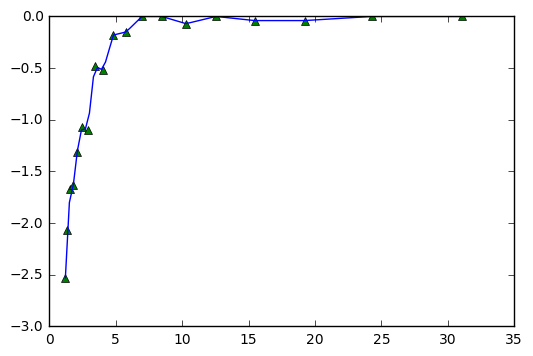

In [84]:
pruning_results = pickle.load(open( "FirstRoundPruningResults.p", "rb" ))

x = [a for (a,_) in pruning_results]
y = [a for (_,a) in pruning_results]
f = interp1d(x, y)
xnew = np.linspace(x[0], x[-1], num=100, endpoint=True)
plt.plot(x, y, 'g^', xnew, f(xnew), '-')

This graph should be compared with Deep Compression's accuracy loss graph:

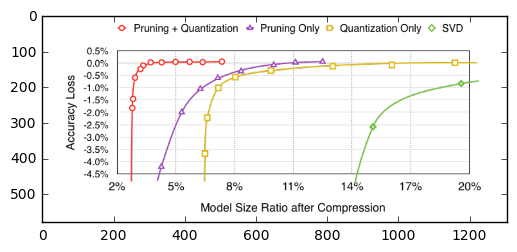

In [86]:
img=mpimg.imread('DeepCompressionAccuracyLoss.png')
plt.imshow(img)

Purple graph on Deep Compression's graph correspond to the blue line in our graph. 

First, the best compression achieved by us without any loss of accuracy was 7%, while they show 8% compression without loss of accuracy. 
Second, the slope of the curve is much steeper in Deep Compression's graph. At 4% size compression they have lost more than 4% of accuracy, while our implementation compresses to 1% of its size with only 2.5% accuracy loss.

These results are comparable, but our implementation seems to yield slightly better accuracy loss/ compression ratio.

### Pruning variation ###

We implemented a slightly modified version of pruning that yielded much better results. Code is available in netprun.py.

The main difference was that we avoided changing weights directly. Instead, we keep the mask up to date and use it to zero out the weights during the forward propagation calculation, but we continue to update the weights with gradients.

We also used a different threshold for each layer, that's dependent on weight sizes and determined by a prate = prune rate parameter that can be passed in to SGD when training. The threshold will then be ~ mean + standard deviation * prate of absolute weights.

The mask is updated after every mini-batch and is ever-changing, but not ever-growing, like before.

With this implementation, and of course constant training and tweaking of hyper parameters, we managed to compress the number of weights to 4% of the original network without loss of accuracy.

First, let's load up the testing data and write up a couple of functions that would help us analyze the differences between pruned and non-pruned network. Both networks are in pickle format for now, which is inconvenient since they are dependent on this codebase, but I will make export functions soon to make them available in different formats.

In [115]:
# load the MNIST data set
training_data, validation_data, test_data = network3.load_data_shared()

# takes a network net and evaluates it against data, returning accuracy
def evaluate(net, data):
    data_x, data_y = data
    
    i = T.lscalar()
    evaluate_accuracy = theano.function(
            [i], net.layers[-1].accuracy(net.y),
            givens={
                net.x: data_x[i*net.mini_batch_size: (i+1)*net.mini_batch_size],
                net.y: data_y[i*net.mini_batch_size: (i+1)*net.mini_batch_size]
            })
    
    num_test_batches = network3.size(data)/net.mini_batch_size
    return str(np.mean([evaluate_accuracy(j) for j in xrange(num_test_batches)]) * 100) + '%'

def percentage_equal_zero(arr):
    return (arr == 0).sum()/float(arr.size)

def hadamard_weights_mask(net):
    allMasks = np.concatenate((net.layers[0].w_mask.eval().ravel(), 
                                 net.layers[1].w_mask.eval().ravel(),
                                 net.layers[2].w_mask.eval().ravel()))
    allWeights = np.concatenate((net.layers[0].w.get_value().ravel(), 
                                net.layers[1].w.get_value().ravel(),
                                net.layers[2].w.get_value().ravel()))
    return allMasks * allWeights

def hadamard_weights_mask_layer(net, index):
    return net.layers[index].w_mask.eval() * net.layers[index].w.get_value()

def pruned_weights_percentage(net):
    return percentage_equal_zero(hadamard_weights_mask(net))

def pruned_weights_percentage_layer(net, index):
    return percentage_equal_zero(hadamard_weights_mask_layer(net, index))
    

Let's load both networks, not-pruned and pruned.

In [90]:
net = pickle.load(open( "netNonPruned.p", "rb" ))
net_pruned = pickle.load(open( "netPruned.p", "rb" ))

In [116]:
print "Accuracy of non-pruned network:", evaluate(net, test_data)
print "Accuracy of pruned network:", evaluate(net_pruned, test_data)
print '\n'
print "% of weights equal to zero in non-pruned network:", pruned_weights_percentage(net)
print "% of weights equal to zero in pruned network", pruned_weights_percentage(net_pruned)
print '\n'
print "Layer 0: % of weights equal to zero in non-pruned network:", pruned_weights_percentage_layer(net, 0)
print "Layer 0: % of weights equal to zero in pruned network", pruned_weights_percentage_layer(net_pruned, 0)
print '\n'
print "Layer 1: % of weights equal to zero in non-pruned network:", pruned_weights_percentage_layer(net, 1)
print "Layer 1: % of weights equal to zero in pruned network", pruned_weights_percentage_layer(net_pruned, 1)
print '\n'
print "Layer 2: % of weights equal to zero in non-pruned network:", pruned_weights_percentage_layer(net, 2)
print "Layer 2: % of weights equal to zero in pruned network", pruned_weights_percentage_layer(net_pruned, 2)

Accuracy of non-pruned network: 98.32%
Accuracy of pruned network: 98.32%


% of weights equal to zero in non-pruned network: 0.0
% of weights equal to zero in pruned network 0.959079639369


Layer 0: % of weights equal to zero in non-pruned network: 0.0
Layer 0: % of weights equal to zero in pruned network 0.959009353741


Layer 1: % of weights equal to zero in non-pruned network: 0.0
Layer 1: % of weights equal to zero in pruned network 0.960433333333


Layer 2: % of weights equal to zero in non-pruned network: 0.0
Layer 2: % of weights equal to zero in pruned network 0.935


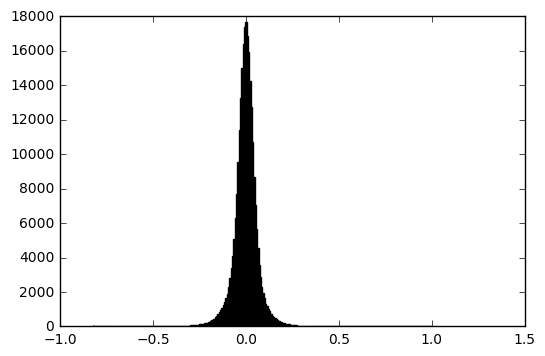

In [94]:
weightsHistogram = plt.hist(hadamard_weights_mask(net), bins=256, fc='k', ec='k')

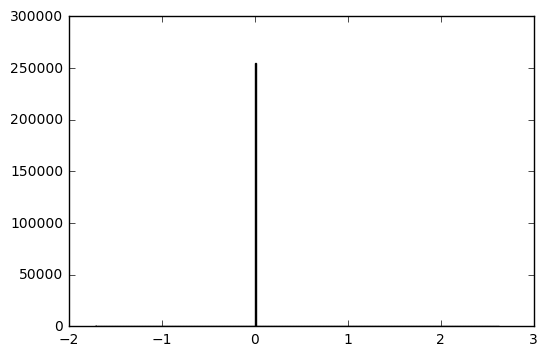

In [95]:
prunedWeightsHistogram = plt.hist(hadamard_weights_mask(net_pruned), bins=256, fc='k', ec='k')

This last histogram doesn't seem very helpful, since most weights have been zeroed out, so we only see one large peak at the zero. Let's try plotting the remaining, non-zero weights of the pruned network:

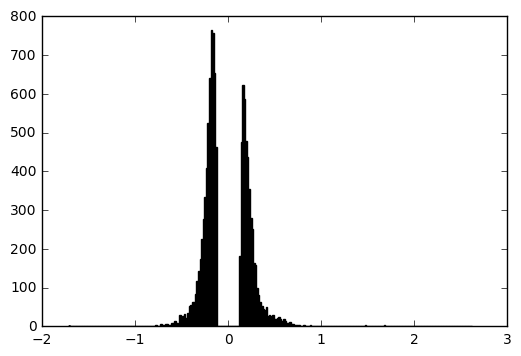

In [97]:
masked_weights = hadamard_weights_mask(net_pruned)
prunedWeightsHistogram = plt.hist(masked_weights[np.absolute(masked_weights) > 0], bins=256, fc='k', ec='k')

Another interesting thing to look at is the heat map and the distribution of non-zero weights in each of the layers.

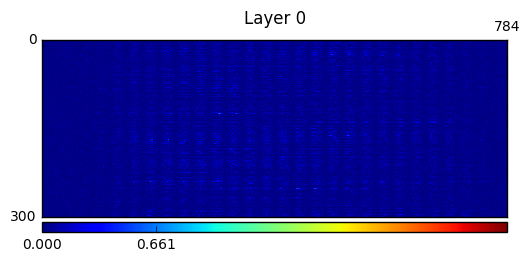

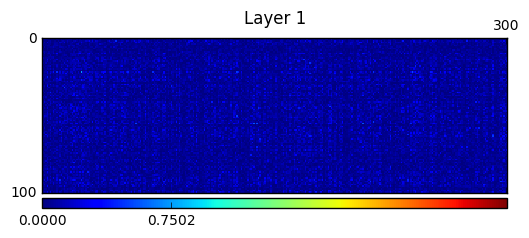

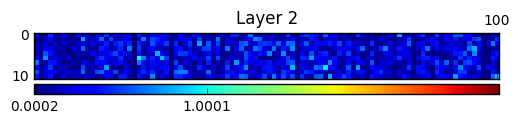

In [110]:
def plot_with_color_bar(toPlot, ls, ind, vmax):
    s = toPlot.shape
    
    plt.figure()
    ax = plt.gca()
    ax.tick_params(labelsize=10, axis='y', length=0)
    
    im = ax.matshow(toPlot, vmin=0, vmax=vmax)
    plt.setp(ax, xticks=[s[1]-1], xticklabels=[str(s[1])], yticks=[0, s[0]-1], yticklabels=[0, str(s[0])])
    ax.set_title("Layer " + str(ind))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size=axes_size.from_any(0.1), pad=0.05)

    plt.colorbar(im, cax=cax, ticks=[np.min(toPlot), np.max(toPlot)], orientation='horizontal')
    
w0 = np.absolute(hadamard_weights_mask_layer(net, 0))
w1 = np.absolute(hadamard_weights_mask_layer(net, 1))
w2 = np.absolute(hadamard_weights_mask_layer(net, 2))

#plt.subplot(3,1,1)
plot_with_color_bar(np.transpose(w0), 10, 0, 2.7)
#plt.subplot(3,2,1)
plot_with_color_bar(np.transpose(w1), 10, 1, 2.7)
#plt.subplot(3,3,1)
plot_with_color_bar(np.transpose(w2), 7, 2, 2.7)

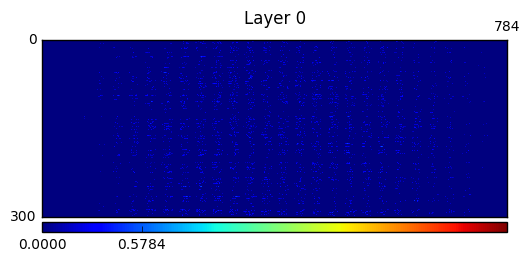

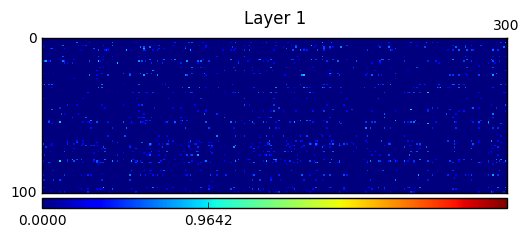

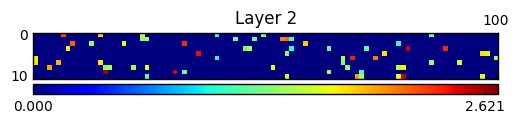

In [111]:
w0 = np.absolute(hadamard_weights_mask_layer(net_pruned, 0))
w1 = np.absolute(hadamard_weights_mask_layer(net_pruned, 1))
w2 = np.absolute(hadamard_weights_mask_layer(net_pruned, 2))

#plt.subplot(3,1,1)
plot_with_color_bar(np.transpose(w0), 10, 0, 2.7)
#plt.subplot(3,2,1)
plot_with_color_bar(np.transpose(w1), 10, 1, 2.7)
#plt.subplot(3,3,1)
plot_with_color_bar(np.transpose(w2), 7, 2, 2.7)

It seems that the pruning had different effects on each layer. All of the heat maps were plotted using the same reference range of the heatbar: 0.0 - 2.7.

By just looking at these graphs, it seems that the layer 0 changed the least. The distribution and scale of the weights looks very similar. This impression probably comes from the heat map range.

Weights magnitudes in both Layer 1 and Layer 2 increased significantly, and it seems that non-zero weights are pretty scattered.